
# Supervised Image Denoising CNN

This notebook trains a simple CNN model to denoise images using a supervised approach.
1. Load and preprocess clean training images, adding synthetic noise.
2. Train the CNN on the noisy/clean image pairs and save the trained model.
3. Load the saved model and test it on a new image (clean or noisy).

## Section 1: Data Loading and Preprocessing

In [1]:
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Use standard tqdm if not in notebook

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

In [2]:
# --- Parameters ---
TRAIN_IMG_DIR = '/kaggle/input/aiml-project/train_images_500' # Directory containing clean training images
TEST_IMG_DIR = '/kaggle/input/aiml-project/test_images_50'   # Directory containing test images (used in Section 3)
MODEL_SAVE_DIR = './'             # Directory to save the trained model

IMG_SIZE = 256          # Resize images to this size (height and width)
BATCH_SIZE = 32         # Number of images per training batch
LEARNING_RATE = 0.001
EPOCHS = 50             # Number of training epochs (adjust as needed)
NOISE_TYPE = 'gauss'    # Noise type for training data: 'gauss' or 'poiss'
NOISE_LEVEL = 25        # Noise level for training (0-255 for Gauss, 0-1 scale for Poisson)

In [3]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create save directory if it doesn't exist
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(TEST_IMG_DIR, exist_ok=True) # Also ensure test dir exists for later use

Using device: cuda


In [4]:
# --- Preprocessing and Noise Functions ---

def preprocess_image(image_path, img_size):
    """Loads, resizes, normalizes, and converts image to PyTorch tensor."""
    try:
        img = Image.open(image_path).convert('RGB')
        img = TF.resize(img, [img_size, img_size])
        img_tensor = TF.to_tensor(img) # Converts to [C, H, W] and scales to [0.0, 1.0]
        return img_tensor
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def add_noise(x, noise_type='gauss', noise_level=25):
    """Adds Gaussian or Poisson noise to a clean image tensor (range [0, 1])."""
    if noise_type == 'gauss':
        # Scale noise_level from 0-255 range to 0-1 range for std deviation
        std_dev = noise_level / 255.0
        noisy = x + torch.randn_like(x) * std_dev
        noisy = torch.clamp(noisy, 0.0, 1.0)
    elif noise_type == 'poiss':
        # Poisson noise level often interpreted differently, assuming noise_level acts as a lambda multiplier
        # Ensure input 'x' is scaled appropriately if needed, here assuming it's already 0-1
        noisy = torch.poisson(noise_level * x) / noise_level
        noisy = torch.clamp(noisy, 0.0, 1.0)
    else:
        print(f"Warning: Unknown noise type '{noise_type}'. Returning original image.")
        noisy = x
    return noisy


In [5]:
# --- Custom Dataset ---

class DenoisingDataset(Dataset):
    def __init__(self, clean_images_list, noise_type, noise_level):
        self.clean_images = clean_images_list
        self.noise_type = noise_type
        self.noise_level = noise_level

    def __len__(self):
        return len(self.clean_images)

    def __getitem__(self, idx):
        clean_img = self.clean_images[idx]
        noisy_img = add_noise(clean_img, self.noise_type, self.noise_level)
        noisy_target = add_noise(clean_img, self.noise_type, self.noise_level)
        return noisy_img, noisy_target

Loading clean training images from: /kaggle/input/aiml-project/train_images_500


Preprocessing Training Images:   0%|          | 0/500 [00:00<?, ?it/s]

Successfully loaded and preprocessed 500 training images.


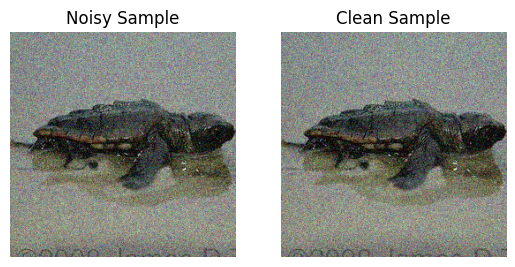

In [6]:
# --- Load Training Data ---

print(f"Loading clean training images from: {TRAIN_IMG_DIR}")
train_image_paths = glob.glob(os.path.join(TRAIN_IMG_DIR, '*.[jJ][pP][gG]')) \
                   + glob.glob(os.path.join(TRAIN_IMG_DIR, '*.[pP][nN][gG]')) \
                   + glob.glob(os.path.join(TRAIN_IMG_DIR, '*.[tT][iI][fF][fF]')) # Add more extensions if needed

if not train_image_paths:
    print(f"Error: No images found in {TRAIN_IMG_DIR}. Please check the path and image files.")
    # Stop execution or handle error appropriately in a real notebook
    raise FileNotFoundError(f"No training images found in {TRAIN_IMG_DIR}")

clean_train_tensors = []
for path in tqdm(train_image_paths, desc="Preprocessing Training Images"):
    tensor = preprocess_image(path, IMG_SIZE)
    if tensor is not None:
        clean_train_tensors.append(tensor)

print(f"Successfully loaded and preprocessed {len(clean_train_tensors)} training images.")

# Create Dataset and DataLoader
train_dataset = DenoisingDataset(clean_train_tensors, NOISE_TYPE, NOISE_LEVEL)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) # Adjust num_workers based on your system

# Optional: Display a sample pair
noisy_sample, clean_sample = train_dataset[0]
fig, ax = plt.subplots(1, 2)
ax[0].imshow(noisy_sample.permute(1, 2, 0))
ax[0].set_title('Noisy Sample')
ax[0].axis('off')
ax[1].imshow(clean_sample.permute(1, 2, 0))
ax[1].set_title('Clean Sample')
ax[1].axis('off')
plt.show()

## Section 2: Model Training and Saving

In [5]:
# --- Define the CNN Model (same architecture as before) ---
class DenoisingCNN(nn.Module):
    def __init__(self, n_chan=3, chan_embed=48):
        super().__init__()
        self.act = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.conv1 = nn.Conv2d(n_chan, chan_embed, 3, padding=1)
        self.conv2 = nn.Conv2d(chan_embed, chan_embed, 3, padding=1)
        self.conv3 = nn.Conv2d(chan_embed, n_chan, 1) # Output has same channels as input

    def forward(self, x):
        # Input x: noisy image
        x1 = self.act(self.conv1(x))
        x2 = self.act(self.conv2(x1))
        output = self.conv3(x2) # Predicts the clean image directly
        # The original ZS-N2N predicted the residual (noise), here we predict the image
        # Make sure the output range is sensible (e.g. clamping might be needed after)
        return output


In [8]:
# --- Training Setup ---
model = DenoisingCNN(n_chan=3).to(device) # Assuming 3 color channels
criterion = nn.MSELoss() # Mean Squared Error between predicted clean and actual clean
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Optional: Learning rate scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=EPOCHS // 3, gamma=0.5)

print(f"Model Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Model Parameters: 22275


Starting Training...


Epoch 1/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/50, Average Loss: 0.105562


Epoch 2/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/50, Average Loss: 0.024043


Epoch 3/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/50, Average Loss: 0.017069


Epoch 4/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/50, Average Loss: 0.014092


Epoch 5/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/50, Average Loss: 0.013150


Epoch 6/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/50, Average Loss: 0.012792


Epoch 7/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/50, Average Loss: 0.012512


Epoch 8/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8/50, Average Loss: 0.012274


Epoch 9/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/50, Average Loss: 0.012043


Epoch 10/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10/50, Average Loss: 0.011824


Epoch 11/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11/50, Average Loss: 0.011621


Epoch 12/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12/50, Average Loss: 0.011444


Epoch 13/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13/50, Average Loss: 0.011296


Epoch 14/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14/50, Average Loss: 0.011173


Epoch 15/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15/50, Average Loss: 0.011095


Epoch 16/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16/50, Average Loss: 0.011032


Epoch 17/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17/50, Average Loss: 0.010988


Epoch 18/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18/50, Average Loss: 0.010951


Epoch 19/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19/50, Average Loss: 0.010921


Epoch 20/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20/50, Average Loss: 0.010890


Epoch 21/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 21/50, Average Loss: 0.010863


Epoch 22/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 22/50, Average Loss: 0.010833


Epoch 23/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 23/50, Average Loss: 0.010806


Epoch 24/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 24/50, Average Loss: 0.010778


Epoch 25/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 25/50, Average Loss: 0.010753


Epoch 26/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 26/50, Average Loss: 0.010724


Epoch 27/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 27/50, Average Loss: 0.010697


Epoch 28/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 28/50, Average Loss: 0.010675


Epoch 29/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 29/50, Average Loss: 0.010657


Epoch 30/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 30/50, Average Loss: 0.010631


Epoch 31/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 31/50, Average Loss: 0.010607


Epoch 32/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 32/50, Average Loss: 0.010586


Epoch 33/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 33/50, Average Loss: 0.010565


Epoch 34/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 34/50, Average Loss: 0.010546


Epoch 35/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 35/50, Average Loss: 0.010529


Epoch 36/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 36/50, Average Loss: 0.010516


Epoch 37/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 37/50, Average Loss: 0.010497


Epoch 38/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 38/50, Average Loss: 0.010476


Epoch 39/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 39/50, Average Loss: 0.010459


Epoch 40/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 40/50, Average Loss: 0.010443


Epoch 41/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 41/50, Average Loss: 0.010433


Epoch 42/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 42/50, Average Loss: 0.010419


Epoch 43/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 43/50, Average Loss: 0.010414


Epoch 44/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 44/50, Average Loss: 0.010395


Epoch 45/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 45/50, Average Loss: 0.010379


Epoch 46/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 46/50, Average Loss: 0.010368


Epoch 47/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 47/50, Average Loss: 0.010355


Epoch 48/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 48/50, Average Loss: 0.010343


Epoch 49/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 49/50, Average Loss: 0.010335


Epoch 50/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 50/50, Average Loss: 0.010323
Training Finished.


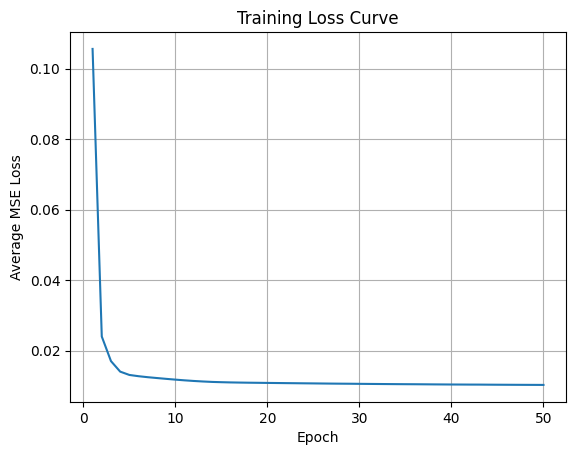

In [9]:
# --- Training Loop ---
print("Starting Training...")
model.train() # Set model to training mode
epoch_losses = []

for epoch in range(EPOCHS):
    running_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)

    for noisy_batch, clean_batch in progress_bar:
        noisy_batch = noisy_batch.to(device)
        clean_batch = clean_batch.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass -> Predict clean image from noisy input
        predicted_clean_batch = model(noisy_batch)

        # Calculate loss
        loss = criterion(predicted_clean_batch, clean_batch)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * noisy_batch.size(0) # loss.item() is avg loss per item in batch
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_dataset)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}, Average Loss: {epoch_loss:.6f}")

    # Step the scheduler (if using one)
    # scheduler.step()

print("Training Finished.")

# Optional: Plot training loss
plt.figure()
plt.plot(range(1, EPOCHS + 1), epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Average MSE Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()


In [10]:
# --- Save the Trained Model ---
model_save_filename = f"{NOISE_TYPE}_cnn_n2n_nl{NOISE_LEVEL}.pth"
model_save_path = os.path.join(MODEL_SAVE_DIR, model_save_filename)

print(f"Saving trained model to: {model_save_path}")
torch.save(model.state_dict(), model_save_path)
print("Model saved successfully.")



Saving trained model to: /kaggle/working/gauss_cnn_n2n_nl25.pth
Model saved successfully.


## Section 3: Testing on a Single Image

In [6]:
# --- Parameters for Testing ---
TEST_IMAGE_PATH = "491.jpg" # <-- CHANGE THIS TO YOUR TEST IMAGE PATH
SAVED_MODEL_FILENAME = f"{NOISE_TYPE}_cnn_n2n_nl{NOISE_LEVEL}.pth" # Should match the saved model name from Section 2
SAVED_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, SAVED_MODEL_FILENAME)

# Set this based on your test image:
TEST_IMAGE_IS_ALREADY_NOISY = False # If True, noise addition step below will be skipped
TEST_NOISE_TYPE = NOISE_TYPE           # Noise type *if* adding noise to a clean test image
TEST_NOISE_LEVEL = NOISE_LEVEL               # Noise level *if* adding noise to a clean test image


In [7]:
# --- Load Saved Model ---
print(f"Loading model from: {SAVED_MODEL_PATH}")
# Ensure the model architecture is defined (it should be if you run cells sequentially)
test_model = DenoisingCNN(n_chan=3).to(device)
try:
    test_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=device))
    test_model.eval() # Set model to evaluation mode (important!)
    print("Model loaded successfully.")
except FileNotFoundError:
    print(f"Error: Model file not found at {SAVED_MODEL_PATH}. Did Section 2 run correctly?")
    # Stop or handle error
    raise FileNotFoundError(f"Model file not found at {SAVED_MODEL_PATH}")
except Exception as e:
     print(f"Error loading model state_dict: {e}")
     raise e

Loading model from: ./gauss_cnn_n2n_nl25.pth
Model loaded successfully.


C:\Users\deban\AppData\Local\Temp\ipykernel_21948\1946807162.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_

In [8]:
# --- Load and Prepare Test Image ---
print(f"Loading test image: {TEST_IMAGE_PATH}")
if not os.path.exists(TEST_IMAGE_PATH):
     print(f"Error: Test image not found at {TEST_IMAGE_PATH}")
     raise FileNotFoundError(f"Test image not found at {TEST_IMAGE_PATH}")

# Preprocess the image (loads as clean, potentially)
input_tensor = preprocess_image(TEST_IMAGE_PATH, IMG_SIZE)

if input_tensor is None:
    print("Failed to process test image.")
    raise ValueError("Test image processing failed.")

input_tensor = input_tensor.to(device)
original_for_display = input_tensor.cpu().clone() # Keep a copy for display before potential noising

# --- Add Noise (if test image is clean) ---
if not TEST_IMAGE_IS_ALREADY_NOISY:
    print(f"Adding {TEST_NOISE_TYPE} noise (level {TEST_NOISE_LEVEL}) to the test image.")
    noisy_input_tensor = add_noise(input_tensor, TEST_NOISE_TYPE, TEST_NOISE_LEVEL)
    # IMPORTANT: Make sure the noise added here matches the type/level the model was trained on if you expect optimal results!
else:
    print("Test image is assumed to be already noisy. Skipping noise addition.")
    noisy_input_tensor = input_tensor # Use the loaded tensor directly as the noisy input

# Add batch dimension for the model
noisy_input_batch = noisy_input_tensor.unsqueeze(0)

Loading test image: 491.jpg
Adding gauss noise (level 25) to the test image.


In [9]:
# --- Perform Denoising ---
print("Denoising the image...")
with torch.no_grad(): # Disable gradient calculation for inference
    denoised_output_batch = test_model(noisy_input_batch)

# Remove batch dimension and clamp output to valid range [0, 1]
denoised_output_tensor = torch.clamp(denoised_output_batch.squeeze(0), 0.0, 1.0)
print("Denoising complete.")

Denoising the image...
Denoising complete.


Displaying Images - PSNR (Noisy vs Clean): 20.43 dB
Displaying Images - PSNR (Denoised vs Clean): 24.62 dB


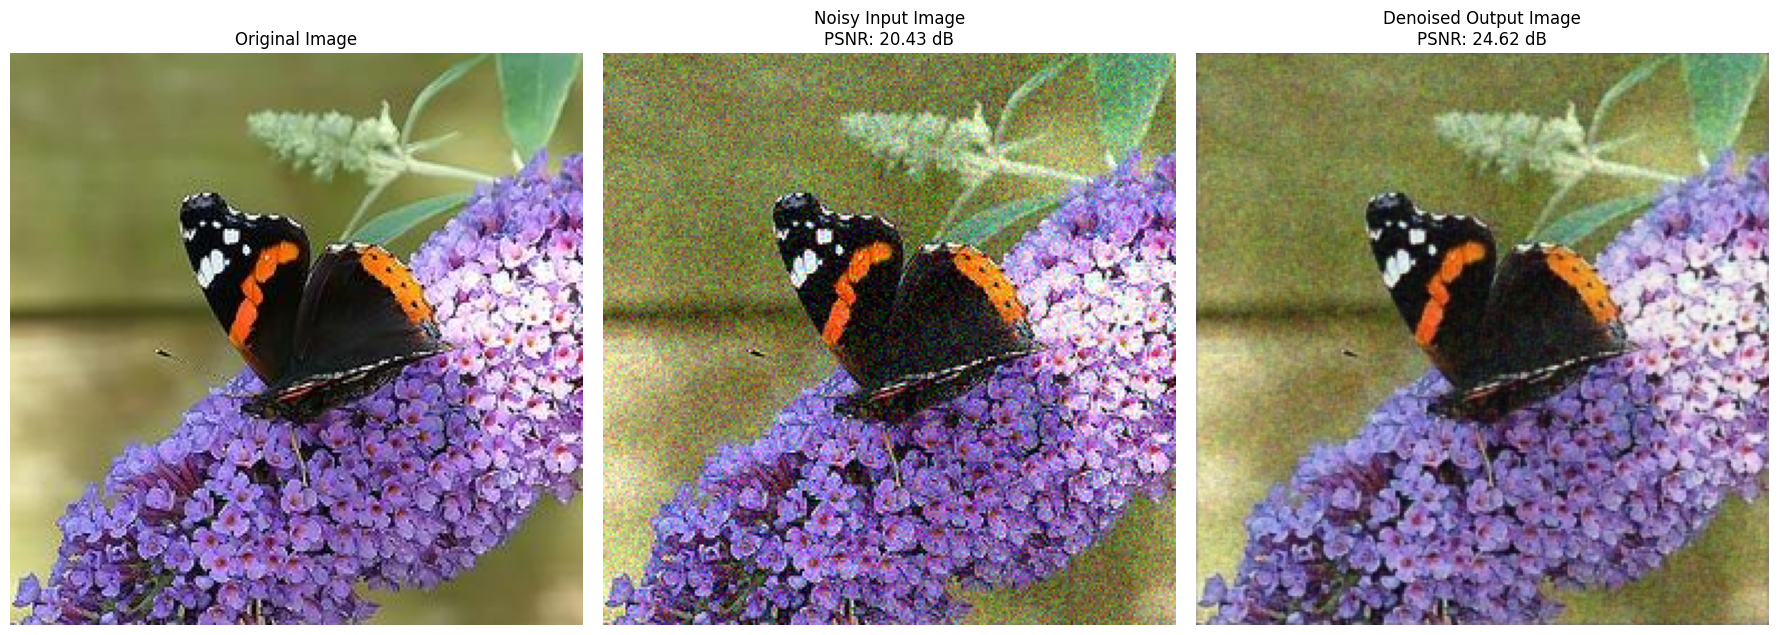

In [10]:
# NOTEBOOK CELL 5 (Updated)

# --- Calculate PSNR Values for Display ---
# Ensure tensors used for comparison are on the correct device
# 'original_for_display' was created as a CPU tensor, move it to the compute device
clean_tensor_device = original_for_display.to(device)
# 'noisy_input_tensor' and 'denoised_output_tensor' should already be on the compute device
# from previous steps

# Calculate PSNR for Noisy vs Clean
mse_noisy = F.mse_loss(noisy_input_tensor, clean_tensor_device)
if mse_noisy.item() > 1e-10: # Avoid log(0)
    psnr_noisy = 10 * torch.log10(1.0 / mse_noisy).item()
else:
    psnr_noisy = float('inf')

# Calculate PSNR for Denoised vs Clean
mse_denoised = F.mse_loss(denoised_output_tensor, clean_tensor_device)
if mse_denoised.item() > 1e-10: # Avoid log(0)
    psnr_denoised = 10 * torch.log10(1.0 / mse_denoised).item()
else:
    psnr_denoised = float('inf')

print(f"Displaying Images - PSNR (Noisy vs Clean): {psnr_noisy:.2f} dB")
print(f"Displaying Images - PSNR (Denoised vs Clean): {psnr_denoised:.2f} dB")


# --- Display Results ---

# Move tensors to CPU and permute C,H,W to H,W,C for matplotlib
# Use the already created CPU copy for the original image
original_display_np = original_for_display.permute(1, 2, 0).numpy()
noisy_display_np = noisy_input_tensor.cpu().permute(1, 2, 0).numpy()
denoised_display_np = denoised_output_tensor.cpu().permute(1, 2, 0).numpy()

fig, ax = plt.subplots(1, 3, figsize=(18, 7)) # Slightly increased height for titles

# Display Original Image
ax[0].imshow(np.clip(original_display_np, 0, 1))
ax[0].set_title('Original Image')
ax[0].axis('off')

# Display Noisy Image with PSNR
ax[1].imshow(np.clip(noisy_display_np, 0, 1))
# Format title to include PSNR value
title_noisy = f'Noisy Input Image\nPSNR: {psnr_noisy:.2f} dB'
ax[1].set_title(title_noisy)
ax[1].axis('off')

# Display Denoised Image with PSNR
ax[2].imshow(np.clip(denoised_display_np, 0, 1))
# Format title to include PSNR value
title_denoised = f'Denoised Output Image\nPSNR: {psnr_denoised:.2f} dB'
ax[2].set_title(title_denoised)
ax[2].axis('off')

plt.tight_layout(pad=1.5) # Add padding to prevent title overlap if needed
plt.show()

# Note: The optional PSNR calculation comparing to a separate ground truth
# file is removed here as the primary request was to show PSNR vs the
# clean input used in this cell's workflow.

In [16]:
# -*- coding: utf-8 -*-
import os
import time # Optional: for timing
import pandas as pd # For saving results to CSV
import numpy as np # For calculating average PSNR

import torch
import torch.nn as nn # Assuming DenoisingCNN uses this
import torch.nn.functional as F # For mse_loss

# NOTE: Ensure necessary libraries like os, torch, pandas, numpy are imported.
# Assume the following are defined earlier in your script:
# - device = 'cuda' or 'cpu'
# - DenoisingCNN class definition
# - preprocess_image(image_path, img_size) function
# - add_noise(image_tensor, noise_type, noise_level, device) function
# - IMG_SIZE (e.g., 256)
# - N_CHAN (e.g., 3)
# - MODEL_SAVE_DIR (e.g., './models')
# - NOISE_TYPE (e.g., 'gauss', matching the saved model)
# - NOISE_LEVEL (e.g., 25, matching the saved model)

N_CHAN = 3 # Number of channels in the images (RGB)

# --- Configuration for Batch Testing ---
TEST_IMG_DIR = '/kaggle/input/aiml-project/test_images_50' # Directory containing the 50 test images
CSV_OUTPUT_FILENAME = f'{NOISE_TYPE}_cnn_n2n_nl{NOISE_LEVEL}.csv'

# Noise parameters to *add* to the clean test images during this test run
# It's crucial these match the conditions the loaded model expects for best results
TEST_NOISE_TYPE = NOISE_TYPE      # Use the same noise type as the loaded model
TEST_NOISE_LEVEL = NOISE_LEVEL    # Use the same noise level as the loaded model

# --- Construct Model Path (using assumed variables) ---
SAVED_MODEL_FILENAME = f"{NOISE_TYPE}_cnn_n2n_nl{NOISE_LEVEL}.pth"
SAVED_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, SAVED_MODEL_FILENAME)

# --- Load Saved Model (Once) ---
print(f"Loading model from: {SAVED_MODEL_PATH}")
# Instantiate the model architecture (ensure N_CHAN is correctly defined above)
test_model = DenoisingCNN(n_chan=N_CHAN).to(device)
try:
    # Load the learned weights
    test_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=device))
    test_model.eval() # Set model to evaluation mode (important!)
    print("Model loaded successfully.")
except FileNotFoundError:
    print(f"Error: Model file not found at {SAVED_MODEL_PATH}. Ensure the path and filename are correct.")
    # Stop or handle error gracefully depending on your workflow
    raise FileNotFoundError(f"Model file not found at {SAVED_MODEL_PATH}")
except Exception as e:
      print(f"Error loading model state_dict: {e}")
      raise e # Re-raise the exception

# --- Prepare for Batch Processing ---
if not os.path.isdir(TEST_IMG_DIR):
    print(f"Error: Test image directory not found: {TEST_IMG_DIR}")
    raise FileNotFoundError(f"Test image directory not found: {TEST_IMG_DIR}")

# Get list of image files (adjust extensions if needed)
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
try:
    all_files = os.listdir(TEST_IMG_DIR)
    image_files = sorted([f for f in all_files if f.lower().endswith(image_extensions)])
except Exception as e:
    print(f"Error listing files in {TEST_IMG_DIR}: {e}")
    raise

if not image_files:
    print(f"No image files with extensions {image_extensions} found in {TEST_IMG_DIR}")
    exit() # Exit if no images to process

print(f"Found {len(image_files)} images to process in {TEST_IMG_DIR}.")

# --- Initialize Results Storage ---
results_data = [] # List to hold {'filename': ..., 'psnr_db': ...} dictionaries

# --- Process Each Image in the Directory ---
print("\nStarting batch denoising and PSNR calculation...")
start_time = time.time() # Optional: time the process

for filename in image_files:
    current_image_path = os.path.join(TEST_IMG_DIR, filename)
    # print(f"Processing: {filename}...") # Uncomment for more verbose output

    try:
        # --- Load and Prepare Test Image (as clean) ---
        # Assumes preprocess_image loads, resizes to IMG_SIZE, returns [0,1] float CHW tensor
        clean_input_tensor = preprocess_image(current_image_path, IMG_SIZE)
        if clean_input_tensor is None:
            print(f"  Skipping {filename} due to preprocessing error.")
            results_data.append({'filename': filename, 'psnr_db': np.nan}) # Record error
            continue # Skip to next image

        clean_input_tensor = clean_input_tensor.to(device)

        # --- Add Noise ---
        # We assume TEST_IMAGE_IS_ALREADY_NOISY is False for all files in this batch test
        noisy_input_tensor = add_noise(clean_input_tensor, TEST_NOISE_TYPE, TEST_NOISE_LEVEL)

        # --- Prepare Batch for Model (B=1) ---
        noisy_input_batch = noisy_input_tensor.unsqueeze(0)

        # --- Perform Denoising ---
        with torch.no_grad(): # Ensure no gradients are calculated
            denoised_output_batch = test_model(noisy_input_batch)

        # Remove batch dimension and clamp output to valid range [0, 1]
        denoised_output_tensor = torch.clamp(denoised_output_batch.squeeze(0), 0.0, 1.0)

        # --- Calculate PSNR (Denoised vs Original Clean) ---
        # Ensure both tensors are on the same device (should be already)
        mse_loss = F.mse_loss(denoised_output_tensor, clean_input_tensor)

        # Calculate PSNR, handle potential zero MSE case
        if mse_loss.item() > 1e-10: # Avoid division by zero or log(0)
            # PSNR for images normalized to [0, 1] has max_val = 1.0
            psnr = 10 * torch.log10(1.0 / mse_loss)
            current_psnr = psnr.item()
        else:
            current_psnr = float('inf') # Assign infinity for perfect reconstruction

        # print(f"  PSNR: {current_psnr:.2f} dB") # Uncomment for verbose output

        # --- Store Result ---
        results_data.append({'filename': filename, 'psnr_db': current_psnr})

    except Exception as e:
        print(f"  Error processing {filename}: {e}")
        # Store NaN or another indicator for the error case
        results_data.append({'filename': filename, 'psnr_db': np.nan})
        # import traceback # Optional: for debugging
        # traceback.print_exc() # Optional: prints traceback

# --- End of Loop ---
end_time = time.time() # Optional
print(f"\nBatch processing completed in {end_time - start_time:.2f} seconds.")

# --- Calculate Average PSNR and Save Results ---
if results_data:
    # Convert results list to a pandas DataFrame
    results_df = pd.DataFrame(results_data)

    # Calculate average PSNR
    # Exclude NaN (errors) and Inf (perfect reconstruction) values for a meaningful average
    valid_psnr_values = results_df['psnr_db'].replace([np.inf, -np.inf], np.nan).dropna()

    if not valid_psnr_values.empty:
        average_psnr = valid_psnr_values.mean()
        print(f"\nAverage PSNR over {len(valid_psnr_values)} successfully processed images: {average_psnr:.2f} dB")
    else:
        average_psnr = np.nan # Indicate no valid results if all failed or were Inf
        print("\nCould not calculate average PSNR (no valid results).")

    # Save the full results DataFrame to CSV
    try:
        results_df.to_csv(CSV_OUTPUT_FILENAME, index=False)
        print(f"Results saved to {CSV_OUTPUT_FILENAME}")
    except Exception as e:
        print(f"Error saving results to CSV ({CSV_OUTPUT_FILENAME}): {e}")
else:
    print("No images were processed.")

print("\nScript finished.")


Batch processing completed in 0.46 seconds.

Average PSNR over 50 successfully processed images: 27.30 dB
Results saved to gauss_cnn_n2n_nl25.csv

Script finished.
